In [5]:
from gworacle import query, mass, snr
from astropy.utils.data import download_file
import json, numpy
from pycbc import init_logging

/home/ahnitz/projects/pycbc/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [6]:
import json
from pycbc.cosmology import redshift
from pycbc.conversions import mchirp_from_mass1_mass2

sigma_scale = 1.65 # Use ~90% interval

events = json.load(open('./class_massest.json', 'r'))
events2 = json.load(open('./massest.json', 'r'))

mchirp_sky = {}
mchirp_sky_val = {}
mchirp_sky_sus = {}
mchirp_sky_sus2 = {}

for event in events2:
    e = events2[event]

    #if e['far'] > 2 / (86400 * 365.25):
    #    continue
    
    z = redshift(e['dist'])

    if e['dist'] - e['distsigma'] * sigma_scale < 0:
        zm = 0
    else:
        zm = redshift(e['dist'] - e['distsigma'] * sigma_scale)

    zp = redshift(e['dist'] + e['distsigma'] * sigma_scale)


    mcd = mchirp_from_mass1_mass2(e['mest'][0], e['mest'][0]) 
    mc = mcd / (1 + z)
    mcl = mc - mcd / (1 + zp)
    mcu = mcd / (1 + zm) - mc
    
    mcd2 = mchirp_from_mass1_mass2(e['mest2'][0], e['mest2'][0]) 
    mc2 = mcd2 / (1 + z)
    mcl2 = mc2 - mcd2 / (1 + zp)
    mcu2 = mcd2 / (1 + zm) - mc2

    if event not in events or events[event]['mest'] is None:
        if e['mlimit'] < e['mest'][0]:
            mchirp_sky_sus[event] = (mc, mcl, mcu, e['snr']['snr'], e['snr']['snr_err'], e['time'])
            mchirp_sky_sus2[event] = (mc2, mcl2, mcu2, e['snr']['snr'], e['snr']['snr_err'], e['time'])
        else:
            mchirp_sky_val[event] = (mc, mcl, mcu, e['snr']['snr'], e['snr']['snr_err'], e['time'])
        
    mchirp_sky[event] = (mc, mcl, mcu, e['snr']['snr'], e['snr']['snr_err'], e['time'])

print(len(mchirp_sky.keys()), len(mchirp_sky_val.keys()), len(mchirp_sky_sus.keys()))


259 219 12


/tmp/ipykernel_227399/405916024.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p1 = plt.errorbar(mc1, snr1, xerr=(mcl, mcu), yerr=(snre*sigma_scale, snre*sigma_scale),
/tmp/ipykernel_227399/405916024.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p3 = plt.errorbar(mc2, snr2, xerr=(mcl + mc2 * 0.2, mcu + mc2 * 0.2),
/tmp/ipykernel_227399/405916024.py:80: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p4 = plt.errorbar(mc4, snr4, xerr=(mcl + mc4 * 0.2, mcu + mc4 * 0.2), yerr=(se * sigma_scale, se * sigma_scale),


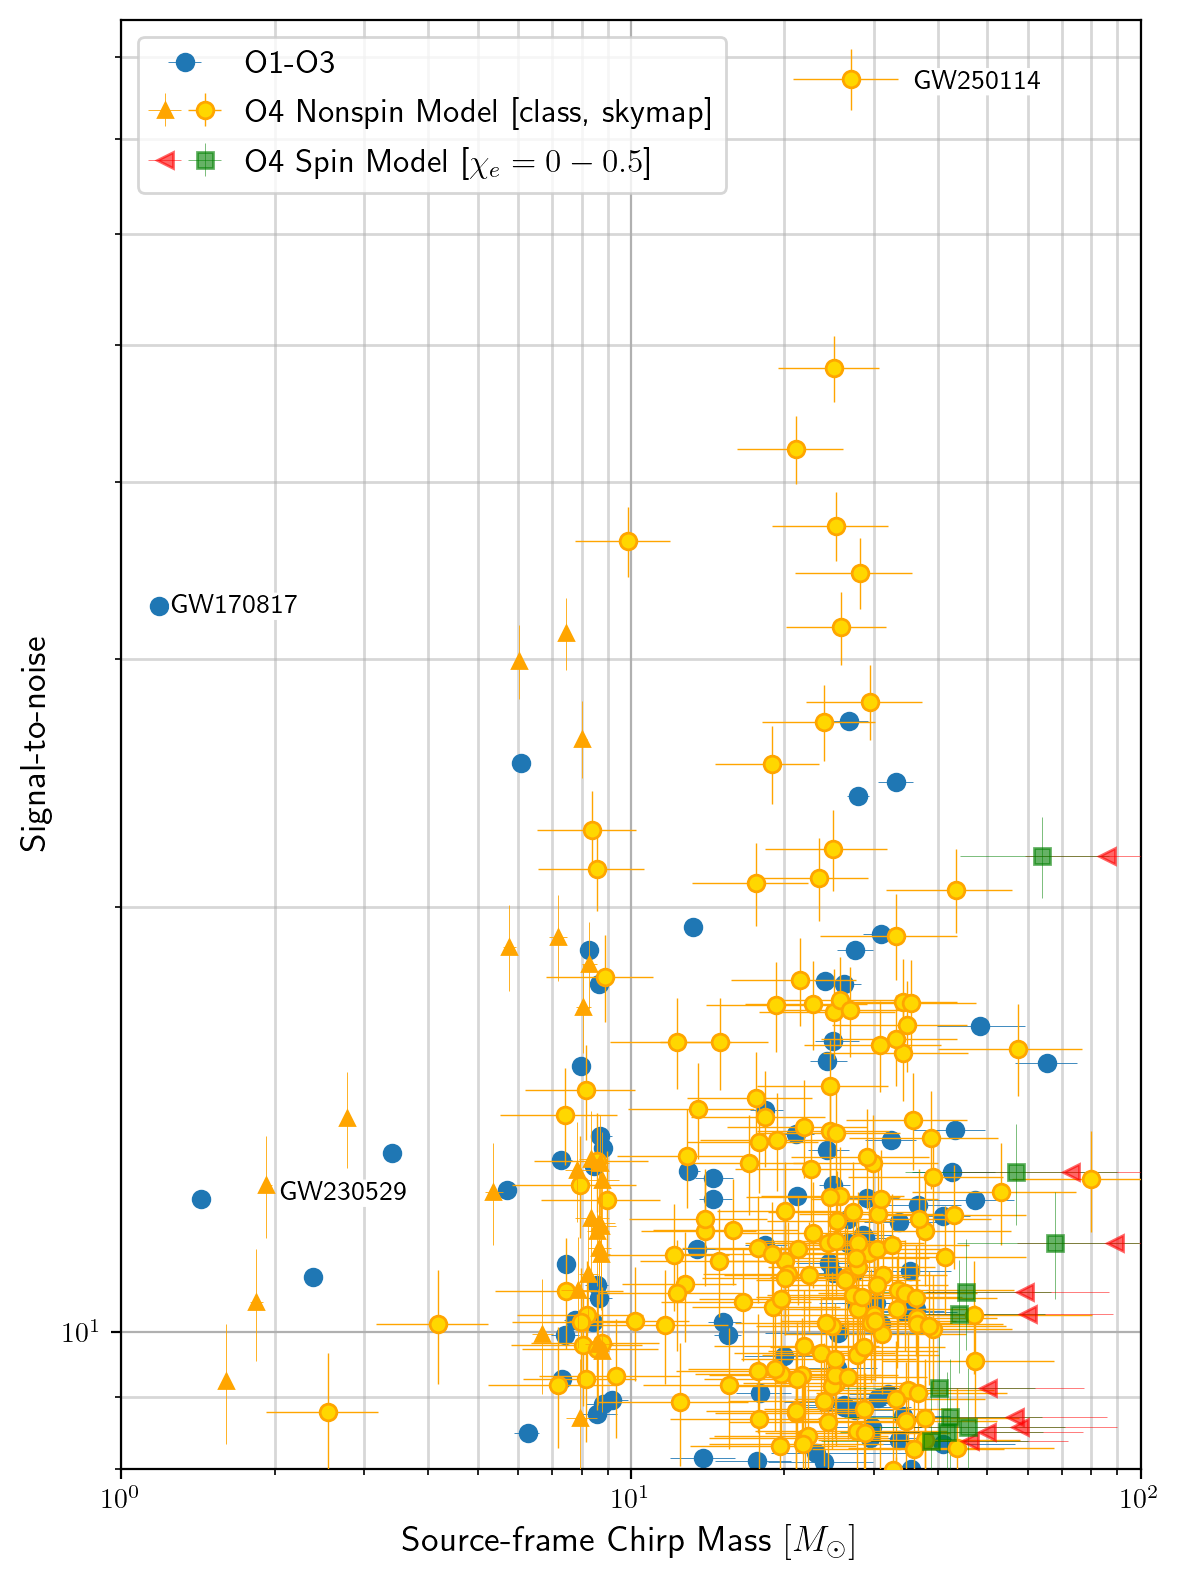

In [7]:
from matplotlib import pyplot as plt
from pycbc.conversions import mchirp_from_mass1_mass2
from astropy.utils.data import download_file
import numpy

sigma_scale = 1.65 # Use ~90% interval

plt.figure(figsize=[6, 8], dpi=200)

#plt.axvspan(1, mchirp_from_mass1_mass2(45, 3), color='gray',
#             zorder=-1, alpha=0.15)
#plt.axvspan(mchirp_from_mass1_mass2(45, 3), 100, color='lightblue',
#            zorder=-1, alpha=0.3)


plt.rc('text', usetex=True)

# Read through 4-ogc text file
names = "event 	 srcmass1 	 srcmass1_plus 	 srcmass1_minus 	 srcmass2 	 srcmass2_plus 	 srcmass2_minus 	 srcmchirp 	 srcmchirp_plus 	 srcmchirp_minus 	 q 	 q_plus 	 q_minus 	 chi_eff 	 chi_eff_plus 	 chi_eff_minus 	 distance 	 distance_plus 	 distance_minus 	 redshift 	 redshift_plus 	 redshift_minus 	 remnantmass 	 remnantmass_plus 	 remnantmass_minus 	 remnantspin 	 remnantspin_plus 	 remnantspin_minus 	 snr 	 detmass1 	 detmass1_plus 	 detmass1_minus 	 detmass2 	 detmass2_plus 	 detmass2_minus 	 detmchirp 	 detmchirp_plus 	 detmchirp_minus 	 detremnantmass 	 detremnantmass_plus 	 detremnantmass_minus".split(' ')
names = [name for name in names if name != '\t']
c = download_file("https://raw.githubusercontent.com/gwastro/4-ogc/refs/heads/master/posterior/PEtable.txt", cache=True)
cat = numpy.genfromtxt(c, dtype=str, delimiter=',')
cat2 = {}
cat2 = {name: numpy.array(cat[:,i+1], dtype=float) for i, name in enumerate(names[1:])}
cat2['event'] = cat[:,0]

snr = cat2['snr']
k = snr > 0
mcc =cat2["srcmchirp"][k]
mcp = cat2["srcmchirp_plus"][k]
mcm = cat2["srcmchirp_minus"][k]
snr = snr[k]

#plt.scatter(mcc, snr, label='O1-O3 [4-OGC]', zorder=100)
p0 = plt.errorbar(mcc, snr, xerr=(mcm, mcp), fmt='o', capsize=0, alpha=1,  elinewidth=0.3)

# Estimates for low mass events
mc1 = numpy.array([events[k]['mest'] for k in events])
snr1 = numpy.array([events[k]['snr']['snr'] for k in events])
snre = numpy.array([events[k]['snr']['snr_err'] for k in events])

distsig = numpy.array([events[k]['distsigma'] for k in events])
dist = numpy.array([events[k]['dist'] for k in events])

zl = redshift(dist - distsig * sigma_scale)
zu = redshift(dist + distsig * sigma_scale)
z = redshift(dist)

mcr = mc1 * (1 + z)
mcu1 = mcu = mcr / (1 + zl) - mc1
mcl1 = mcl = mc1 - mcr / (1 + zu)
p1 = plt.errorbar(mc1, snr1, xerr=(mcl, mcu), yerr=(snre*sigma_scale, snre*sigma_scale),
             color='orange', label='O4 [class]', capsize=0, fmt='o', zorder=200, marker='^', markersize=5,  elinewidth=0.3)
plt.ylabel('Signal-to-noise', fontsize=13)


mc3 = numpy.array([mchirp_sky_val[e][0] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
mc3l = mcl = numpy.array([mchirp_sky_val[e][1] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
mc3u = mcu = numpy.array([mchirp_sky_val[e][2] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
snr3 = numpy.array([mchirp_sky_val[e][3] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
se = numpy.array([mchirp_sky_val[e][4] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
p2 = plt.errorbar(mc3, snr3, xerr=(mcl + mc3 * 0.2, mcu + mc3 * 0.2), yerr=(se * sigma_scale, se * sigma_scale),
             color='orange', label='O4 [sky]', capsize=0, fmt='o', zorder=100, alpha=1.0, 
                  markerfacecolor='gold', elinewidth=0.5)


mc2 = numpy.array([mchirp_sky_sus[e][0] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218]) 
mcl = numpy.array([mchirp_sky_sus[e][1] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
mcu = numpy.array([mchirp_sky_sus[e][2] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
snr2 = numpy.array([mchirp_sky_sus[e][3] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
se = numpy.array([mchirp_sky_sus[e][4] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
p3 = plt.errorbar(mc2, snr2, xerr=(mcl + mc2 * 0.2, mcu + mc2 * 0.2),
             color='red', label='O4 [$\chi_e = 0 -> 0.5$]', capsize=0, fmt='o', zorder=100, alpha=0.6, marker='<',  elinewidth=0.3)

mc4 = numpy.array([mchirp_sky_sus2[e][0] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
mcl = numpy.array([mchirp_sky_sus2[e][1] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
mcu = numpy.array([mchirp_sky_sus2[e][2] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
snr4 = numpy.array([mchirp_sky_sus2[e][3] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
se = numpy.array([mchirp_sky_sus2[e][4] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
p4 = plt.errorbar(mc4, snr4, xerr=(mcl + mc4 * 0.2, mcu + mc4 * 0.2), yerr=(se * sigma_scale, se * sigma_scale),
             color='green', capsize=0, fmt='o', zorder=100, alpha=0.6, marker='s',  elinewidth=0.3)


from matplotlib.legend_handler import HandlerTuple
lgnd = plt.legend([p0, (p1, p2), (p3, p4)],
                  ["O1-O3", "O4 Nonspin Model [class, skymap]", "O4 Spin Model [$\chi_e = 0-0.5$]"],
                     handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12)


#print(len(mc), len(mcc[mcc<10]))

plt.text(1.25, 32.3, "GW170817", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.0'))
plt.text(2.05, 12.4, "GW230529", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.0'))
plt.text(36, 76, "GW250114", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.0'))

plt.grid(True, which='minor', alpha=0.5, linewidth=1)
plt.grid(True, which='major')
plt.yscale('log')
plt.xlim(1, 100)
plt.ylim(8, 85)
plt.minorticks_on()
plt.xscale('log')
plt.xlabel('Source-frame Chirp Mass $[M_\\odot]$', fontsize=13)
plt.tight_layout()
plt.savefig('pop.pdf')


302 198 94 28 10 170
213 144 64 23 5 121


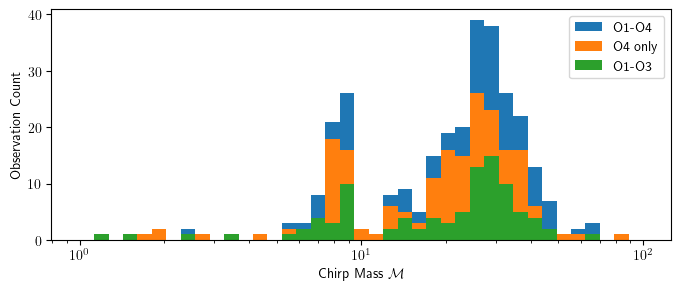

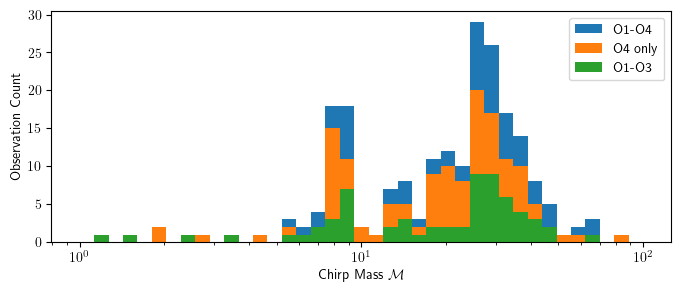

In [8]:
mc_tot = numpy.concatenate([mcc, mc1, mc4,  mc3])
mc_tot_04 = numpy.concatenate([mc1, mc3])

print(len(mc_tot), len(mc_tot_04), len(mcc), len(mc1), len(mc2), len(mc3))

plt.figure(figsize=[8, 3])
bins = numpy.geomspace(1, 100, 40)

plt.hist(mc_tot, bins=bins, label='O1-O4')
plt.hist(mc_tot_04, bins=bins, label='O4 only')
plt.hist(mcc, bins=bins, label='O1-O3')
plt.legend()
plt.xscale('log')
plt.xlabel('Chirp Mass $\mathcal{M}$')
plt.ylabel('Observation Count')
plt.savefig('mdis.pdf')

sthresh = 10
mc_tot = numpy.concatenate([mcc[snr>sthresh], mc1[snr1>sthresh], mc4[snr4>sthresh],  mc3[snr3>sthresh]])
mc_tot_04 = numpy.concatenate([mc1[snr1>sthresh], mc3[snr3>sthresh]])

print(len(mc_tot), len(mc_tot_04), len(mcc[snr>sthresh]), len(mc1[snr1>sthresh]), len(mc2[snr2>sthresh]), len(mc3[snr3>sthresh]))

plt.figure(figsize=[8, 3])
bins = numpy.geomspace(1, 100, 40)

plt.hist(mc_tot, bins=bins, label='O1-O4')
plt.hist(mc_tot_04, bins=bins, label='O4 only')
plt.hist(mcc[snr>sthresh], bins=bins, label='O1-O3')
plt.legend()
plt.xscale('log')
plt.xlabel('Chirp Mass $\mathcal{M}$')
plt.ylabel('Observation Count')
plt.savefig('mdis.pdf')

GW190513_205428 21.193349721782255 16.723816871781686 S190513bm -0.21089317680663003
GW191109_010717 48.394844670255445 37.090128448321536 S191109d -0.23359339820098732
GW190521_030229 65.40784515162532 82.86961364841758 S190521g 0.2669674938275864
GW190814_211039 6.084136123812357 4.726483676910611 S190814bv -0.22314629707052516
GW190706_222641 42.71627311267745 78.51253584271826 S190706ai 0.8380006054277499
GW190517_055101 26.645178831740548 42.10019499614455 S190517h 0.5800304911443686
40 -0.019017225549819917
S250328ae 8.023674320375923 8.413962914769286
S250211aa 8.719070542918693 9.402888790663422
S250206dm 1.8419061097365435 1.9855169717043482
S250205bk 8.679778938438162 9.019209071961269
S250118az 8.782981918693993 6.738977620254475
S241231bg 8.277490843415608 8.619209057771922
S241109bn 5.366485568189106 5.5524721497520195
S240925n 7.454927469091548 6.588033175842637
S240916ar 7.941214509237326 7.18615542052622
S240915b 8.06100127920064 8.09616161285105
S240910ci 7.17892456036

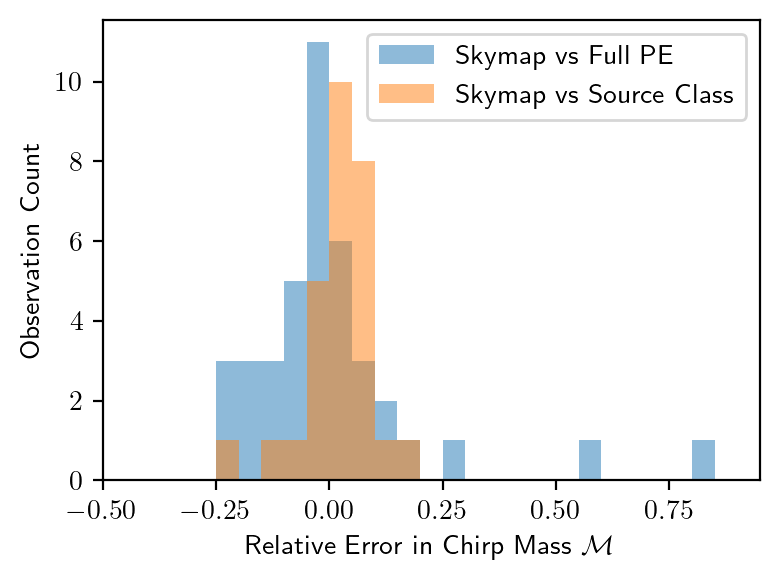

In [9]:
from matplotlib import pyplot as plt
from pycbc.conversions import mchirp_from_mass1_mass2
from astropy.utils.data import download_file
import numpy

mcl, mc, mcu, s, se = [], [], [], [], []
cat = numpy.genfromtxt("./4ogc.txt", dtype=str)
names = [k[1] for k in cat]
ogc_times = numpy.array([float(k[2]) for k in cat])
otimes = {names[i]: ogc_times[i] for i in range(len(names))}

keep = []
est = {}
nm = {}
for e in mchirp_sky:
    t = mchirp_sky[e][5]
    if numpy.any(abs(t - ogc_times) < 1):
        #mcl.append(mchirp_sky[e][0])
        mc.append(mchirp_sky[e][0])
        #mcu.append(mchirp_sky[e][2])
        s.append(mchirp_sky[e][3])
        se.append(mchirp_sky[e][4])

        j = numpy.where(abs(t - ogc_times) < 1)[0][0]
        keep.append(names[j])
        est[names[j]] = mc[-1]
        nm[names[j]] = e

#mcl = numpy.array(mcl)
mc = numpy.array(mc)
#mcu = numpy.array(mcu)
s = numpy.array(s)
se = numpy.array(se)

# Read through 4-ogc text file
names = "event 	 srcmass1 	 srcmass1_plus 	 srcmass1_minus 	 srcmass2 	 srcmass2_plus 	 srcmass2_minus 	 srcmchirp 	 srcmchirp_plus 	 srcmchirp_minus 	 q 	 q_plus 	 q_minus 	 chi_eff 	 chi_eff_plus 	 chi_eff_minus 	 distance 	 distance_plus 	 distance_minus 	 redshift 	 redshift_plus 	 redshift_minus 	 remnantmass 	 remnantmass_plus 	 remnantmass_minus 	 remnantspin 	 remnantspin_plus 	 remnantspin_minus 	 snr 	 detmass1 	 detmass1_plus 	 detmass1_minus 	 detmass2 	 detmass2_plus 	 detmass2_minus 	 detmchirp 	 detmchirp_plus 	 detmchirp_minus 	 detremnantmass 	 detremnantmass_plus 	 detremnantmass_minus".split(' ')
names = [name for name in names if name != '\t']
c = download_file("https://raw.githubusercontent.com/gwastro/4-ogc/refs/heads/master/posterior/PEtable.txt", cache=True)
cat = numpy.genfromtxt(c, dtype=str, delimiter=',')
cat2 = {}
cat2 = {name: numpy.array(cat[:,i+1], dtype=float) for i, name in enumerate(names[1:])}
cat2['event'] = cat[:,0]

ogc = {}
for i, event in enumerate(cat2['event']):
    ogc[event] = cat2["srcmchirp"][i]

i = 0
ogc_mid = []
est_mid = []
for event in ogc:
    if event in est:
        if abs(ogc[event] - est[event]) / ogc[event] > 0.200:
            print(event, ogc[event], est[event], nm[event], -1 * (ogc[event] - est[event]) / ogc[event])
        i += 1
        ogc_mid.append(ogc[event])
        est_mid.append(est[event])
ogc_mid = numpy.array(ogc_mid)
est_mid = numpy.array(est_mid)

# 190706 & 190517 has high spin and is consistent if we account for this in the template, rather than assuming zero spin
# 190814 - underestimate the masses due to mass ratio
# 190602 and 190521 are both cases where there is significant discrepency between the initial an final estimates

diff = (est_mid - ogc_mid) / ogc_mid
bias = numpy.median(diff)
print(len(diff), bias)
diff.sort()


mc1 = []
mc2 = []
for event in mchirp_sky:
    if event in events:
        if events[event]['mest'] is not None:
            mc1.append(events[event]['mest'])
            mc2.append(mchirp_sky[event][0])
            print(event, mc1[-1], mc2[-1])

mc1 = numpy.array(mc1)
mc2 = numpy.array(mc2)

plt.figure(figsize=[4, 3], dpi=200)
diff2 = (mc2 - mc1) / mc1

bias = numpy.median(diff2)
print(len(diff2), bias)
diff2.sort()

bins = numpy.arange(-0.5, 1, 0.05)

plt.rc('text', usetex=True)
plt.hist(diff, bins=bins, alpha=0.5, label='Skymap vs Full PE')
plt.hist(diff2, bins=bins, alpha=0.5,label='Skymap vs Source Class')
plt.xlabel('Relative Error in Chirp Mass $\mathcal{M}$')
plt.xlim(-0.5, 0.95)
plt.ylabel('Observation Count')
plt.legend()
plt.tight_layout()
plt.savefig('syst.pdf')